# 'Presidential' Meme Search Engine
## Creators: Nigel Hardy and Scott Ligon

Our corpus consists of links to memes, number of likes, the network they originate from, the text from the meme obtained by OCR, and the time the meme was posted. Originally there were multiple csv files containing memes about Bernie Sanders, Hillary Clinton, Donald Trump, and a few others. We used pandas to remove newline characters and build a cleaner dataset that was ready to be searched in our notebook.


In [167]:
# IMPORT VARIOUS LIBRARIES
import pandas as pd
import datetime
import urllib2
from IPython.display import display
from pyparsing import makeHTMLTags, withAttribute, Optional, Group
from IPython.core.display import HTML
from difflib import SequenceMatcher
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import indicoio
indicoio.config.api_key = 'b669130e3e1d07909794d8e5b7a6b11e'

# Old code
This is the code we used to import the csv file and clean it to get ready for searching. We ended up saving the dataframe into a new csv in order to speed of the process of getting started.

tldr; You don't need to run this code, but it won't cause a problem either.

In [196]:
# original import data DONT RUN ANYMORE
'''trump = pd.read_csv("clean.csv", index_col=["id"],
        usecols=["id", "caption", "likes", "network", "link","timestamp"], 
                    dtype={"id": int, "caption": str,"link":str, "likes": int, "network":str, "timestamp":str})'''
# nrows=10 # limit read csv rows read
#list(trump.columns.values) # used to list columns
#print trump.head()
wordCount = 0
rowCount = 0
#trump.drop_duplicates(subset='caption', keep='last') #get rid of identical captions
def clean():
    wCount = 0
    rCount = 0
    for index, row in trump.iterrows():
        row["caption"] = row["caption"].replace("\\n", "")
        row["caption"] = row["caption"].lower()
        wCount += len(row["caption"].split())
        rCount += 1
        trump.set_value(index, "caption", row["caption"])
        trump.set_value(index, "timestamp", datetime.datetime.strptime(row["timestamp"], "%Y-%m-%d %H:%M:%S"))
        sent = 0
        try:
            string = row["caption"].encode(encoding='UTF-8',errors='strict')
            sent = indicoio.sentiment(string)
            sent = (sent - .5) * 2
        except:
            sent = 0
        trump.set_value(index, "sentiment", sent)
    info = {}
    info["words"] = wCount # total number of words
    info["rows"] = rCount # number of rows
    info["avgWords"] = wCount / rCount # ang words in each document
    return info

#info = clean()
#trump.to_csv("clean-sentiment.csv")
print("Done")

                   timestamp                      link  \
id                                                       
668802   2016-06-02 12:01:00  http://imgur.com/a/wOoTe   
3088663  2016-10-23 07:50:00  http://imgur.com/Y8SzGVV   
3116976  2016-10-23 07:50:00  http://imgur.com/Y8SzGVV   
2731705  2016-10-09 07:32:00  http://imgur.com/2d5AxL6   
2622676  2016-09-29 04:29:00  http://imgur.com/a/OTBU6   

                                                   caption network  likes  
id                                                                         
668802   ooooo rogers 11:47 pm t 25% upandoutcomic bern...   imgur     -4  
3088663  the "communism is too extreme" starter pack gr...   imgur      0  
3116976  the "communism is too extreme" starter pack gr...   imgur      0  
2731705  is snoop dogg cute ugly? i just wanted to know...   imgur      0  
2622676  discuss ctr infiltrators! are w next target???...   imgur      0  
Done


# Loading in data
Here we import the data and get some basic information regarding how many words and results are in the corpus. We have just over 30,000 different memes to search through.

In [220]:
# run to get data into python/notebook

class qResults: # class for query results
    def __init__(self, caption, network, likes, link, timestamp, sentiment):
        self.caption = caption
        self.link = link
        self.network = network
        self.likes = likes
        self.score = 0
        self.timestamp = timestamp
        self.sentiment = sentiment
        
def getInfo():
    wCount = 0
    rCount = 0
    for index, row in trump.iterrows():
        wCount += len(row["caption"].split())
        rCount += 1
    info = {}
    info["words"] = wCount # total number of words
    info["rows"] = rCount # number of rows
    info["avgWords"] = wCount / rCount # ang words in each document
    return info
# read already cleaned dataset
trump = pd.read_csv("clean-sentiment.csv", index_col=["id"],
        usecols=["id", "caption", "likes", "network", "link","timestamp", "sentiment"], 
                    dtype={"id": int, "caption": str,"link":str, "likes": int, "network":str, "timestamp":str, "sentiment": float})
info = getInfo() # get some basic info on dataframe
#print list(trump.columns.values)
print("Done")

Done


### Facebook script to embed posts
Please reload page after searching to make them show up

In [303]:
#facebook script for display of memes
htmlScript = """<div id="fb-root"></div>
<script>(function(d, s, id) {
  var js, fjs = d.getElementsByTagName(s)[0];
  if (d.getElementById(id)) return;
  js = d.createElement(s); js.id = id;
  js.src = "//connect.facebook.net/en_US/sdk.js#xfbml=1&version=v2.8";
  fjs.parentNode.insertBefore(js, fjs);
}(document, 'script', 'facebook-jssdk'));</script>"""
htmlScr = HTML(htmlScript)
display(htmlScr)

### Basic search and displaying of results
We started with BM25 and then applied number of likes as well

Displaying the results to get help assess the effectiveness of our search was important. The captions alone do not tell the whole story. We have checked for similar memes (there are a lot of slight variations that we are excluding) and made sure the links were still active. This was one of the most time consuming parts of our project. Once it was working we were able to refine the search. It made us aware of the duplicates. Luckily most images had widly different numbers of likes and that helped them get differentiated.

In [299]:
def search(query):
    global trump # dataframe of memes
    results = [] # list for results
    qFrequency = {} # dictionary for frequency of each word in query
    query = query.lower() # make consistent
    qSplit = query.split()
    if len(qSplit) > 1: # query has two or more words
        for qry in qSplit:
            qFrequency[qry] = 0
    else:
        qFrequency[query] = 0
    qSplit = query.split() # split into each word
    for index, row in trump.iterrows():
        if len(query.split()) > 0: # query has two or more words
            allFound = True # all words query must be present to keep
            for qry in qSplit: # go through each word in query string
                if qry in row["caption"]:
                    qFrequency[qry] += row["caption"].count(qry) # increment frequency of word in dataset       
                else:
                    allFound = False; # skip, not all words in query found
            if allFound is True:
                newResult = qResults(row["caption"], row["network"], row["likes"], row["link"], row["timestamp"], row["sentiment"])
                results.append(newResult) 
    res = {} # init dict to return
    res["rows"] = results # each results in a list
    res["qf"] = qFrequency # frequency of terms in a dictionary
    return res

def printResults(results, limit, showCaption, showScore, showSentiment):
    count = 0
    htmlStr = "<html><body>" # begin html string
    style = "style=\"width:50%;\" " # for images formatting
    for r in results:
        if count >= limit: #stop after limit
            break
        else:
            if r.network == "instagram":
                tempurl = "https://www.{0}/".format(r.link[8:len(r.link)])
                try:
                    response = urllib2.urlopen(tempurl) # check if exists
                    html = response.read()
                    meta,metaEnd = makeHTMLTags("meta")
                    img_meta = meta.copy().setParseAction(withAttribute(('property','og:image'))) # get image
                    if showScore is True:
                        htmlStr += '<p>Score: ' + str(r.score) + '</p>'
                    if showCaption is True:
                        htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'
                    if showSentiment is True:
                        htmlStr += '<p>Sentiment: ' + str(r.sentiment) + '</p>'
                    htmlStr += "<img " + style + "src='" + img_meta.searchString(html)[0].content + "'>" # show images
                    
                except:
                    """htmlStr += '<br><p>Instagram Image Not Found :(<br>'
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'"""
                    limit += 1
            elif r.network == "imgur":
                tempurl = r.link
                try:
                    response = urllib2.urlopen(tempurl) # check if link is valid
                    html = response.read()
                    meta,metaEnd = makeHTMLTags("meta")
                    img_meta = meta.copy().setParseAction(withAttribute(('name','twitter:image'))) # find image
                    if showScore is True:
                        htmlStr += '<p>Score: ' + str(r.score) + '</p>'
                    if showCaption is True:
                        htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'
                    if showSentiment is True:
                        htmlStr += '<p>Sentiment: ' + str(r.sentiment) + '</p>'
                    htmlStr += "<img " + style + "src='" + img_meta.searchString(html)[0].content + "'>" # show images
                except:
                    """htmlStr += '<br><p>Imgur Image Not Found :(<br>'
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'"""
                    limit += 1

            elif r.network == "facebook":
                try:
                    response = urllib2.urlopen(r.link) # check if link is valid
                    if showScore is True:
                        htmlStr += '<p>Score: ' + str(r.score) + '</p>'
                    if showCaption is True:
                        htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'
                    if showSentiment is True:
                        htmlStr += '<p>Sentiment: ' + str(r.sentiment) + '</p>'
                    htmlStr += """<div class="fb-post" data-href="{0}" 
                    data-width="500" data-show-text="true"><blockquote cite="{0}" 
                    class="fb-xfbml-parse-ignore">Posted by <a href="https://www.facebook.com/facebook/">Facebook</a> on&nbsp;
                    <a href="{0}">{1}</a>
                    </blockquote></div>""".format(r.link, str(r.timestamp))
                except:
                    limit += 1
                            
        count += 1
    htmlStr += "</body></html>" # end html
    html = HTML(htmlStr) 
    display(html) # show html
    
def similar(a, b): # check similarity of two strings
    return SequenceMatcher(None, a, b).ratio()

def getScores(results, info, sentiment):
    # BM25 Variables
    k = 1.2
    b = .75
    for r in results["rows"]:
        r.score = 0
        if r.network == "imgur" or r.network == "instagram" or r.network == "facebook":
        #if r.network == "imgur" or r.network == "instagram": # witout facebook
            for q in results["qf"]: # give bm25 based score
                fqd = r.caption.count(q)
                tempScore = ((fqd * (k + 1) / (fqd + k * (1 - b + b * len(r.caption) / info["avgWords"]))))
                tempScore *= (info["rows"] - results["qf"][q] + .5) / (results["qf"][q] + .5)
                likeScore = r.likes * .1
                maxLikeInfluence = 10
                if likeScore > maxLikeInfluence:
                    likeScore = maxLikeInfluence
                elif likeScore < -maxLikeInfluence:
                    likeScore = -maxLikeInfluence
                tempScore += likeScore
                r.score += tempScore

    return results

def noDuplicates(results, limit):
    count = 0
    dupFree = [] # no caption duplicates
    index = 0
    if(len(results["rows"]) > 0):
        dupFree.append(results["rows"][index]) # add first to list
        index += 1
        dupLimit = limit * 1.5 # get extra in case links are dead
        if dupLimit > len(results["rows"]):
            dupLimit = len(results["rows"])
        while len(dupFree) < dupLimit and index < len(results["rows"]):
            dupFound = False # catch if similar caption found
            for i in dupFree:
                if similar(i.caption, results["rows"][index].caption) > .8: # checks similarity
                    dupFound = True # duplicate found, don't add
            if dupFound == False:
                dupFree.append(results["rows"][index]) # not a dup, add it
            index += 1
    else:
        print "No results found."
    return dupFree

## Enter the query below.

In [302]:
# SEARCH HERE
query = "build the wall"

results=search(query)  # get results
results = getScores(results, info, True) # last boolean adds sentiment to score (positive is better)
results["rows"] = sorted(results["rows"],key=lambda qResults: qResults.score, reverse=True)
limit = 10 # how many results to display
dupFree = noDuplicates(results, limit)
print "Results: " + str(len(results["rows"]))
showCaption = True # show caption
showScore = True # show score
showSentiment = True # show sentiment value -1 to 1
printResults(dupFree, limit, showCaption, showScore, showSentiment)

Results: 192


### Feedback
The first feedback we recieved or interpreted was the disappointed originally when the actual memes themselves were not displayed. However, once they were duplicates (or similar) memes was the next most annoying part of the problem. It was also fairly slow, because the images had to be fetched from the internet each time. 

The next problem we faced was a high score for images with a lot of text. We had made a mistake in our implementation of tf-idf, so fixing that helped make the scores more meaningful. 

In hindsight, we could have spent more time making it scalable and fast using spark, but ultimately the most time consuming part of the process is displaying the images. We believe that this part was crucial and so prioritized it, but if we had more time that would have been the next step.

In [277]:
timeResults = sorted(results["rows"],key=lambda qResults: qResults.timestamp, reverse=True)
sentimentCaptions = {}
indicoCaptions = []
sentimentCaptions["caption"] = []
sentimentCaptions["sentiment"] = []
count = 0
for tRes in timeResults:
    if count % 2 == 0 and count < 20: # add every 2 (or however many)
        try:
            sentimentCaptions["caption"].append(tRes.caption.encode(encoding='UTF-8',errors='strict'))
        except:
            nothing = 0 # do nothing ** for indent
    count += 1
count = 0
sent = indicoio.sentiment(sentimentCaptions["caption"])
for s in sent:
    sentimentCaptions["sentiment"].append(s)
    count += 1
count = 0


### The code above and below this comment helps display the chart that utilizes an api from inidicio. Over time, the bars represent how strong the query shows up within memes.
There were no strong correlations, partially because the sentiment detection was not always accurate, and the captions were short. This was largely abandoned, but we added sentiment to the search ranking (30,000 api calls!)

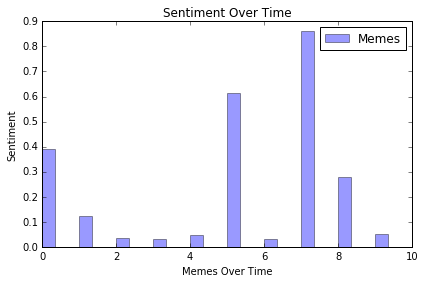

Results: 10 from: 


In [279]:
n_groups = len(sent)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
    
rects1 = plt.bar(index, sentimentCaptions["sentiment"], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Memes')


plt.xlabel('Memes Over Time')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.legend()
plt.tight_layout()
plt.show()
showInfo = "Results: " + str(len(sentimentCaptions["sentiment"])) + " from: "
print(showInfo)

## Experimentation
We experimented with a little bit a spark, but had too many other projects due and did not get to actually implementing it into our project.

In [280]:
import findspark
import os
findspark.init(os.getenv('HOME') + '/spark-1.6.0-bin-hadoop2.6')
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'

In [281]:
print len(trump)
import pyspark
try: 
    print(sc)
except NameError:
    sc = pyspark.SparkContext()
    print(sc)
from pyspark import SQLContext
sqlc = SQLContext(sc)
    
df = sqlc.createDataFrame(trump)
sqlc.registerDataFrameAsTable(df, 'caption')
sqlc.sql("select timestamp, caption from caption where likes > 0").show()

30072
+-------------------+--------------------+
|          timestamp|             caption|
+-------------------+--------------------+
|2016-10-29 19:26:00|with both of the ...|
|2016-07-29 20:52:00|obama has been ki...|
|2016-06-21 04:00:00|nut for honorlici...|
|2016-09-11 17:34:00|(was zaryai sahme...|
|2016-10-17 05:11:00|someone setfireto...|
|2016-06-02 01:34:00|81 9:31 pm at&t m...|
|2016-05-17 02:20:00|       feel the bern|
|2016-03-18 12:30:00|stare into the be...|
|2016-04-21 03:38:00|trump hillary, fe...|
|2016-04-06 03:25:00|a chelsea clinton...|
|2016-03-04 05:43:00|nie >i was only 9...|
|2015-02-21 12:15:00|there is a 500-ye...|
|2016-06-26 17:33:00|ok- whoever the e...|
|2016-05-16 02:52:00|bernaste the bern...|
|2016-04-25 13:27:00|when you accident...|
|2016-10-18 16:37:00|m beijo bern cari...|
|2016-08-28 21:29:00|"you just can't m...|
|2016-05-03 06:17:00|feel the eel ti f...|
|2016-07-25 22:45:00|my aesthetic is t...|
|2016-05-08 17:35:00|tch ept noseusted...|
+----